# Packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants

# Data

In [2]:
#Directory:
dataDir = '../analysis_data/result_6(99spec)'
#dataDir = '../analysis_data/result_5(5specTest)'
resultDir = dataDir+'/result3'

In [3]:
def retrieveData(fileName):
    data = np.load(resultDir+'/'+fileName)
    return data['ch1'], data['ch2'], data['ch3'], data['ch4']

In [4]:
#Input data:
stkData = np.load(dataDir+'/stkData.npz')
wvl_ch1, flux_ch1, err_ch1 = stkData['ch1']
wvl_ch2, flux_ch2, err_ch2 = stkData['ch2']
wvl_ch3, flux_ch3, err_ch3 = stkData['ch3']
wvl_ch4, flux_ch4, err_ch4 = stkData['ch4']

In [5]:
#Consvervative results:
consvResult = np.load(resultDir+'/consvResult.npz')
wvl_bd_ch1, consvGammaBd_ch1, consvCouplingBd_ch1 = consvResult['ch1']
wvl_bd_ch2, consvGammaBd_ch2, consvCouplingBd_ch2 = consvResult['ch2']
wvl_bd_ch3, consvGammaBd_ch3, consvCouplingBd_ch3 = consvResult['ch3']
wvl_bd_ch4, consvGammaBd_ch4, consvCouplingBd_ch4 = consvResult['ch4']
#Conservative chi2 and gamma:
consvChi2_ch1, consvChi2_ch2, consvChi2_ch3, consvChi2_ch4 = retrieveData('consvChi2.npz')
gammaTest1_consv, gammaTest2_consv, gammaTest3_consv, gammaTest4_consv = retrieveData('gammaTest_consv.npz')

In [6]:
#Continuum results:
contResult = np.load(resultDir+'/contResult.npz')
_, contGammaBd_ch1, contCouplingBd_ch1, N1 = contResult['ch1']
_, contGammaBd_ch2, contCouplingBd_ch2, N2 = contResult['ch2']
_, contGammaBd_ch3, contCouplingBd_ch3, N3 = contResult['ch3']
_, contGammaBd_ch4, contCouplingBd_ch4, N4 = contResult['ch4']
#Conservative chi2 and gamma
contChi2_ch1, contChi2_ch2, contChi2_ch3, contChi2_ch4 = retrieveData('contChi2.npz')
gammaTest1_cont, gammaTest2_cont, gammaTest3_cont, gammaTest4_cont = retrieveData('gammaTest_cont.npz')
#Model fits:
modelFit_ch1, modelFit_ch2, modelFit_ch3, modelFit_ch4 = retrieveData('modelFit.npz')

In [7]:
#Sensitivity bands:
gammaBand_ch1, gammaBand_ch2, gammaBand_ch3, gammaBand_ch4 = retrieveData('gammaBand.npz')
simGammaBd_ch1, simGammaBd_ch2, simGammaBd_ch3, simGammaBd_ch4, = retrieveData('simGammaBd.npz')
#Simulated data:
simData_ch1, simData_ch2, simData_ch3, simData_ch4 = retrieveData('simData.npz')
#Simulated fits:
simFit_ch1, simFit_ch2, simFit_ch3, simFit_ch4 = retrieveData('simFit.npz') 
#Simulated chi2:
simChi2_ch1, simChi2_ch2, simChi2_ch3, simChi2_ch4 = retrieveData('simChi2.npz')

In [8]:
params = np.loadtxt(resultDir+'/params.txt')
testRange = int(params[5])
dof = 2*testRange
step = int(params[7])

In [9]:
#Other constraints:
consDir = '../constraints'
gcData = np.loadtxt(consDir+'/GlobularClusters.txt')
gcM, gcLim = np.transpose(gcData)
nirspcData = np.loadtxt(consDir+'/nirspc.txt')
nirspcM, nirspcLim = np.transpose(nirspcData)

# Functions

In [103]:
def wvlToMass(wvl):
    #um to eV
    return 2*constants.Planck*constants.c/wvl/constants.e/1e-6
    
def gammaToCoupling(gamma,ma):  
    #s-1 => GeV-1
    g = np.sqrt(64*np.pi*658.2119569*gamma/ma**3)
    return g

def model_range(i,wvl,flux,error):
    if (i>=testRange) & (i<=len(wvl)-testRange):
        wvlCut = wvl[i-testRange:i+testRange]
        fluxCut = flux[i-testRange:i+testRange]
        errorCut = error[i-testRange:i+testRange]
    elif (i<testRange):
        wvlCut = wvl[:testRange*2]
        fluxCut = flux[:testRange*2]
        errorCut = error[:testRange*2]
    elif (i>len(wvl)-testRange):
        wvlCut = wvl[-testRange*2:]
        fluxCut = flux[-testRange*2:]
        errorCut = error[-testRange*2:]
    return wvlCut,fluxCut,errorCut
    
def consvChi2AgstGamma(wvl,gammaArr,chi2,xrange=(0,0.5e-23),yrange=(-5,10),interv=100,n=5,fileName=''):
    plt.figure(figsize=(9,6))
    for i in range(n):
        plt.plot(gammaArr,chi2[i*interv,:],'--o',label='$\\lambda_0=$'+str(np.round(wvl[i*interv])))
    plt.legend()
    plt.xlim(xrange)
    plt.ylim(yrange)
    plt.xlabel('$\\Gamma_\\gamma$')
    plt.ylabel('$\\chi^2$')
    if not (fileName==''):
        plt.savefig(fileName)
    plt.show()
    
def showConstraints(wvl,consvGammaBd,consvCouplingBd,contGammaBd,contCouplingBd,gammaBand):
    massArr = wvlToMass(wvl)
    gamma1sigup = gammaBand[:,0,0]  #gammaBand[:,0]+gammaBand[:,1]
    gamma1siglow = gammaBand[:,0,1]  #gammaBand[:,0]-gammaBand[:,1]
    gamma2sigup = gammaBand[:,1,0]  #gammaBand[:,0]+2*gammaBand[:,1]
    gamma2siglow = gammaBand[:,1,1]  #gammaBand[:,0]-2*gammaBand[:,1]
    couple1sigup = gammaToCoupling(gamma1siglow,massArr)
    couple1siglow = gammaToCoupling(gamma1sigup,massArr)
    couple2sigup = gammaToCoupling(gamma2siglow,massArr)
    couple2siglow = gammaToCoupling(gamma2sigup,massArr)
    
    plt.subplot(211)
    plt.plot(massArr,1/contGammaBd,color='firebrick')
    #plt.plot(massArr,1/consvGammaBd,'--',color='black')
    plt.fill_between(massArr,1/gamma2sigup,1/gamma2siglow,color='yellow')
    plt.fill_between(massArr,1/gamma1sigup,1/gamma1siglow,color='lawngreen')   
    plt.xscale('log')
    plt.yscale('log')
    plt.xlim(5e-2,1)
    #plt.xticks((0.1,0.5,0.7,1))
    plt.ylim(1e21,1e29)
    plt.yticks((1e23,1e26,1e29))
    plt.xlabel('$m_a$ [eV]')
    plt.ylabel('$\\tau$ [sec]')
    
    plt.subplot(212)
    plt.plot(massArr,contCouplingBd,color='firebrick')
    #plt.plot(massArr,consvCouplingBd,'--',color='black')
    plt.fill_between(massArr,couple2sigup,couple2siglow,color='yellow')
    plt.fill_between(massArr,couple1sigup,couple1siglow,color='lawngreen')
    plt.yscale('log')
    plt.xscale('log')
    plt.xlim(5e-2,1)
    #plt.xticks((1,3,6))
    plt.ylim((1e-12,1e-6))
    plt.yticks([1e-11,1e-9,1e-7])
    plt.xlabel('$m_a$ [eV]')
    plt.ylabel('$g_{\\alpha\\gamma\\gamma}$ [GeV$^{-1}$]')
    plt.tight_layout(pad=0.9)   
    
def fitting_result(wvl, flux, error, wvl_bd, gammaArr, chi2, N, modelFit=np.array([]), simData=np.array([]), simFit=np.array([]), plot_i=np.inf, sim_i=0, N_lim=(0,12), flux_lim=(), plotRange=100): #gamma_lim=(0,5e-24), chi2_lim=(0,5)     
    
    #Detection significance:
    plt.figure(figsize=(9,6))
    plt.plot(wvl_bd,N)
    plt.ylim(N_lim)
    plt.axhline(y = 5, color = 'grey', linestyle = '--') 
    plt.xlabel('Wavelength ($\\mu$m)')
    plt.ylabel('N')
    plt.show()
    print('Significant detections:')
    for i in range(len(N)):
        if N[i]>5:
            print('N =', "{:.2f}".format(N[i]), 'at (\u03BB_0,i) =', ("{:.2f}".format(wvl_bd[i]),i))
    max_i = np.argmax(N)
    print('Strongest detection:')
    print('N =', "{:.2f}".format(N[max_i]), 'at (\u03BB_0,i) =', ("{:.2f}".format(wvl_bd[max_i]),max_i))
    
    #Fitting for a specific mass:
    if not (plot_i == np.inf):
        plt.figure(figsize=(9, 6))
        #Spectrum:
        wvl_model, flux_model, error_model = model_range(plot_i*step,wvl,flux,error)  
        plt.subplot(211)
        plt.step(wvl_model,flux_model,'black',label='MRS')
        plt.fill_between(wvl_model,flux_model+error_model,flux_model-error_model,step="pre",color='silver')
        if not (len(modelFit)==0):
            plt.plot(wvl_model,modelFit[plot_i,:,0],color='red',label='Bestfit')
            plt.plot(wvl_model,modelFit[plot_i,:,1],color='blue',label='Bound')
            plt.plot(wvl_model,modelFit[plot_i,:,2],color='cyan',label='Null')
        if not (len(simData)==0):
            plt.scatter(wvl_model,simData[plot_i,sim_i,:],marker='x',s=20,color='green',label='Simulated data')
        if not (len(simFit)==0):
            plt.plot(wvl_model,simFit[plot_i,sim_i,:,0],'--',color='orange',label='sBestfit')
            plt.plot(wvl_model,simFit[plot_i,sim_i,:,1],'--',color='magenta',label='sBound')
            plt.plot(wvl_model,simFit[plot_i,sim_i,:,2],'--',color='navy',label='sNull')
        plt.legend()
        if not(flux_lim==()):
            plt.ylim(flux_lim)
        plt.xlabel('Wavelength ($\\mu$m)')
        plt.ylabel("$\\Phi$ (MJy/sr)")

        #Chi2 against gamma
        min_i = np.argmin(chi2[plot_i,:])
        if min_i<plotRange:
            start_i = 0
            end_i = min_i + plotRange
        elif (len(gammaArr)-min_i-1)<plotRange:
            start_i = min_i - plotRange
            end_i = len(gammaArr)
        else:
            start_i = min_i - plotRange
            end_i = min_i + plotRange
        plt.subplot(212)
        plt.plot(gammaArr[start_i:end_i],chi2[plot_i,start_i:end_i],'-o')
        plt.axhline(y = chi2[plot_i,0], color = 'grey', linestyle = '--') 
        # plt.ylim(chi2_lim)
        # plt.xlim(gamma_lim)
        plt.xlabel('$\\Gamma$ (Hz)')
        plt.ylabel('$\\chi^2$')
        plt.tight_layout(pad=0.9)   
        plt.show() 
        print('chi2 =', np.min(chi2[plot_i,:]), 'N =', N[plot_i])

def chi2Dof(wvl1,chi1,wvl2,chi2,wvl3,chi3,wvl4,chi4,figName='chi2Dof.pdf',Null=False):
    if (Null==True):
        chi2dof1 = chi1[:,0]/dof
        chi2dof2 = chi2[:,0]/dof
        chi2dof3 = chi3[:,0]/dof
        chi2dof4 = chi4[:,0]/dof
    else:
        chi2dof1 = np.min(chi1,axis=1)/dof
        chi2dof2 = np.min(chi2,axis=1)/dof
        chi2dof3 = np.min(chi3,axis=1)/dof
        chi2dof4 = np.min(chi4,axis=1)/dof
    plt.figure(figsize=(9, 6))
    plt.plot(wvl1,chi2dof1)
    plt.plot(wvl2,chi2dof2)
    plt.plot(wvl3,chi2dof3)
    plt.plot(wvl4,chi2dof4)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('$\\chi^2/$d.o.f')
    plt.legend(('Ch1','Ch2','Ch3','Ch4'))
    plt.axhline(y = 1, color = 'grey', linestyle = '--')
    if not (figName==''):
        plt.savefig(figName)
    plt.show()

# Plots

## I) Conservative constraints

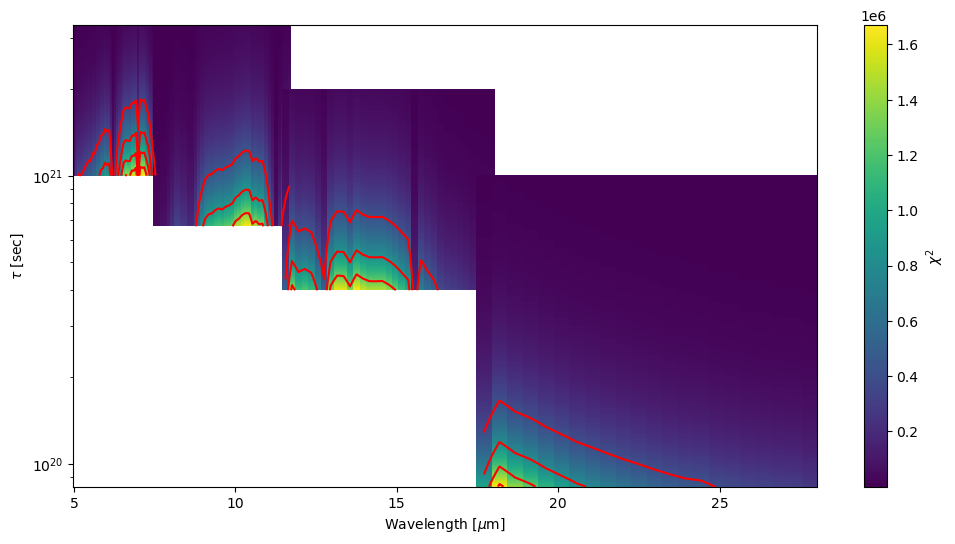

In [11]:
#gammaBd vs wvl
c = 4
wvl1, gammaTest1 = np.meshgrid(wvl_bd_ch1, gammaTest1_consv)
wvl2, gammaTest2 = np.meshgrid(wvl_bd_ch2, gammaTest2_consv)
wvl3, gammaTest3 = np.meshgrid(wvl_bd_ch3, gammaTest3_consv)
wvl4, gammaTest4 = np.meshgrid(wvl_bd_ch4, gammaTest4_consv)
plt.figure(figsize=(12,6))
plt.pcolormesh(wvl1, 1/gammaTest1, np.transpose(consvChi2_ch1))
plt.pcolormesh(wvl2, 1/gammaTest2, np.transpose(consvChi2_ch2))
plt.pcolormesh(wvl3, 1/gammaTest3, np.transpose(consvChi2_ch3))
plt.pcolormesh(wvl4, 1/gammaTest4, np.transpose(consvChi2_ch4))
plt.colorbar(label='$\\chi^2$')
plt.contour(wvl1, 1/gammaTest1, np.transpose(consvChi2_ch1), c, colors='red')
plt.contour(wvl2, 1/gammaTest2, np.transpose(consvChi2_ch2), c, colors='red')
plt.contour(wvl3, 1/gammaTest3, np.transpose(consvChi2_ch3), c, colors='red')
plt.contour(wvl4, 1/gammaTest4, np.transpose(consvChi2_ch4), c, colors='red')
plt.xlabel('Wavelength [$\\mu$m]')
plt.ylabel('$\\tau$ [sec]')
plt.yscale('log')
plt.show()

In [12]:
print(gammaTest1_consv)

[3.00000000e-22 3.00452396e-22 3.00905473e-22 3.01359235e-22
 3.01813680e-22 3.02268811e-22 3.02724627e-22 3.03181132e-22
 3.03638325e-22 3.04096207e-22 3.04554779e-22 3.05014044e-22
 3.05474000e-22 3.05934651e-22 3.06395996e-22 3.06858036e-22
 3.07320774e-22 3.07784209e-22 3.08248343e-22 3.08713177e-22
 3.09178712e-22 3.09644949e-22 3.10111889e-22 3.10579533e-22
 3.11047883e-22 3.11516938e-22 3.11986701e-22 3.12457173e-22
 3.12928354e-22 3.13400245e-22 3.13872848e-22 3.14346164e-22
 3.14820193e-22 3.15294938e-22 3.15770398e-22 3.16246575e-22
 3.16723470e-22 3.17201084e-22 3.17679419e-22 3.18158475e-22
 3.18638253e-22 3.19118755e-22 3.19599982e-22 3.20081934e-22
 3.20564613e-22 3.21048019e-22 3.21532155e-22 3.22017021e-22
 3.22502618e-22 3.22988947e-22 3.23476010e-22 3.23963807e-22
 3.24452340e-22 3.24941609e-22 3.25431616e-22 3.25922362e-22
 3.26413849e-22 3.26906076e-22 3.27399046e-22 3.27892759e-22
 3.28387216e-22 3.28882419e-22 3.29378369e-22 3.29875067e-22
 3.30372514e-22 3.308707

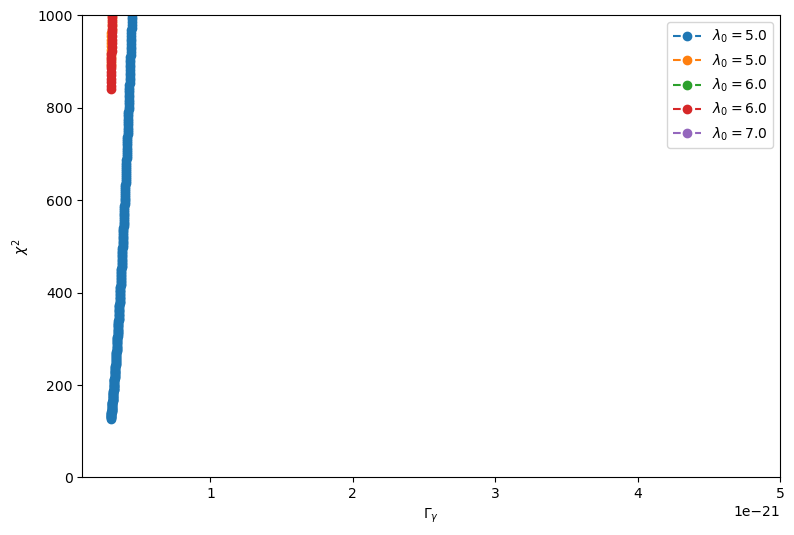

In [13]:
#chi2 vs gamma
consvChi2AgstGamma(wvl_bd_ch1,gammaTest1_consv,consvChi2_ch1,interv=6,xrange=(1e-22,5e-21),yrange=(0,1000))

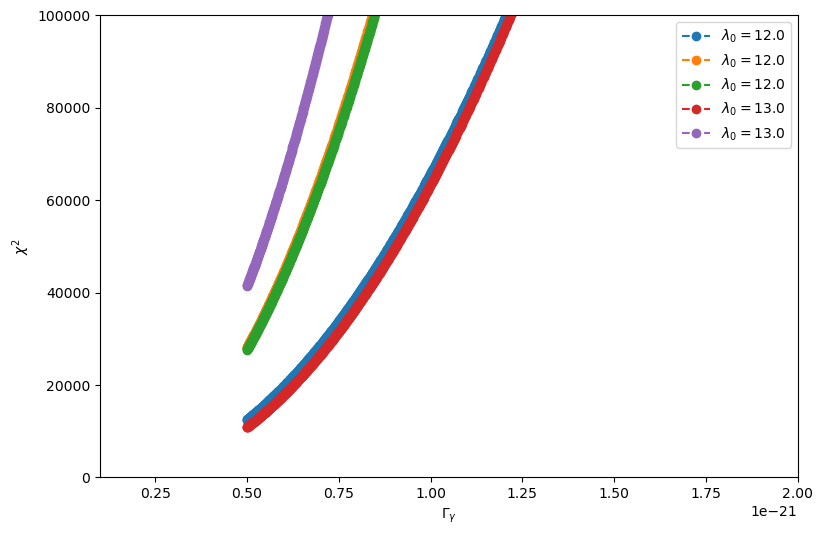

In [14]:
consvChi2AgstGamma(wvl_bd_ch3,gammaTest3_consv,consvChi2_ch3,interv=2,xrange=(1e-22,2e-21),yrange=(0,100000))

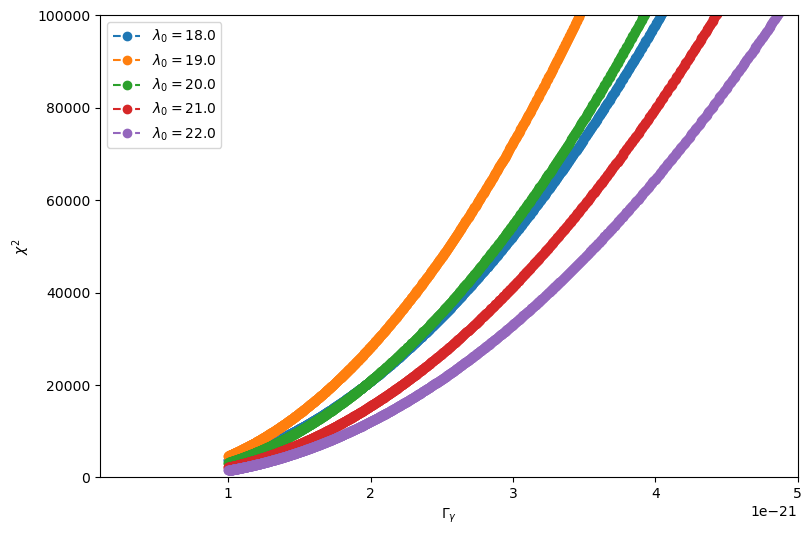

In [15]:
consvChi2AgstGamma(wvl_bd_ch4,gammaTest4_consv,consvChi2_ch4,interv=2,xrange=(1e-22,5e-21),yrange=(0,100000))

## II) Continuum constraints

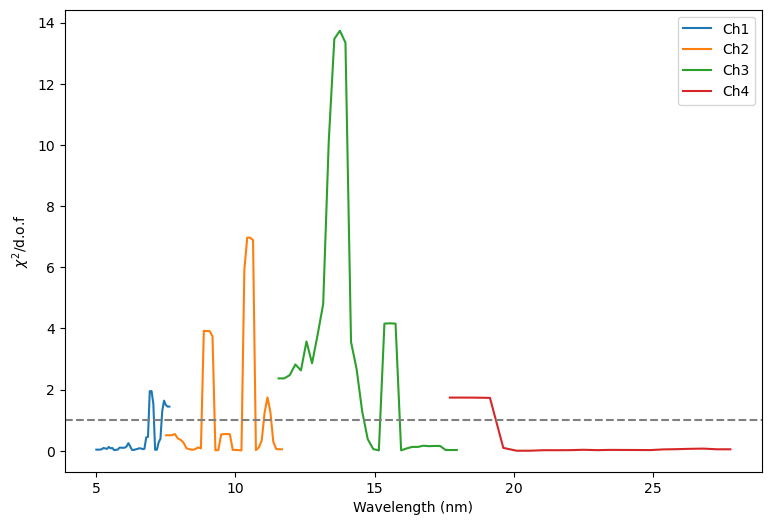

In [16]:
#Goodness of fits:
chi2Dof(wvl_bd_ch1,contChi2_ch1,wvl_bd_ch2,contChi2_ch2,wvl_bd_ch3,contChi2_ch3,wvl_bd_ch4,contChi2_ch4,Null=True)

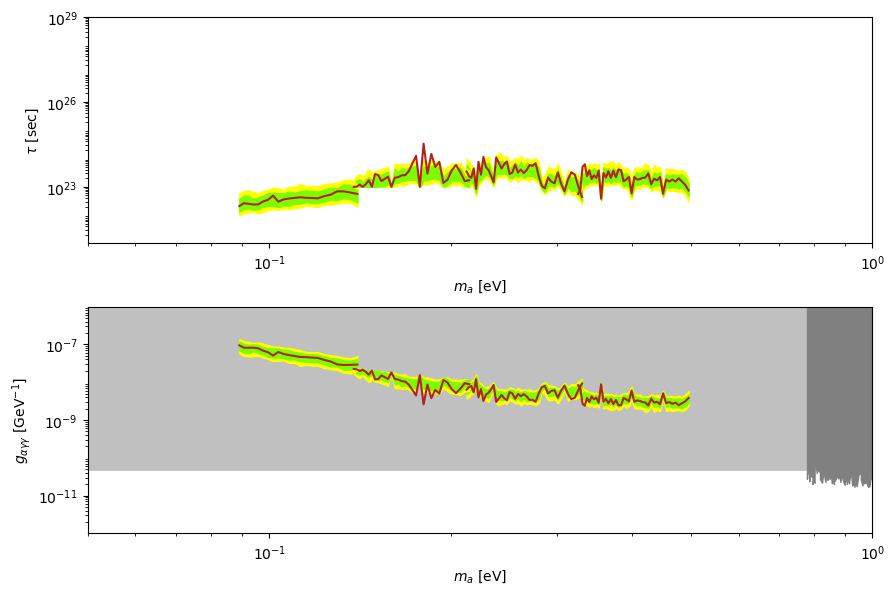

In [17]:
#Constraints:
plt.figure(figsize=(9, 6))
plt.subplot(212)
plt.fill_between(gcM,gcLim,1e-6,color='silver')
plt.fill_between(nirspcM,nirspcLim,1e-6,color='grey')
showConstraints(wvl_bd_ch1,consvGammaBd_ch1,consvCouplingBd_ch1,contGammaBd_ch1,contCouplingBd_ch1,gammaBand_ch1)
showConstraints(wvl_bd_ch2,consvGammaBd_ch2,consvCouplingBd_ch2,contGammaBd_ch2,contCouplingBd_ch2,gammaBand_ch2)
showConstraints(wvl_bd_ch3,consvGammaBd_ch3,consvCouplingBd_ch3,contGammaBd_ch3,contCouplingBd_ch3,gammaBand_ch3)
showConstraints(wvl_bd_ch4,consvGammaBd_ch4,consvCouplingBd_ch4,contGammaBd_ch4,contCouplingBd_ch4,gammaBand_ch4)
plt.savefig('constraints.pdf')
plt.show()

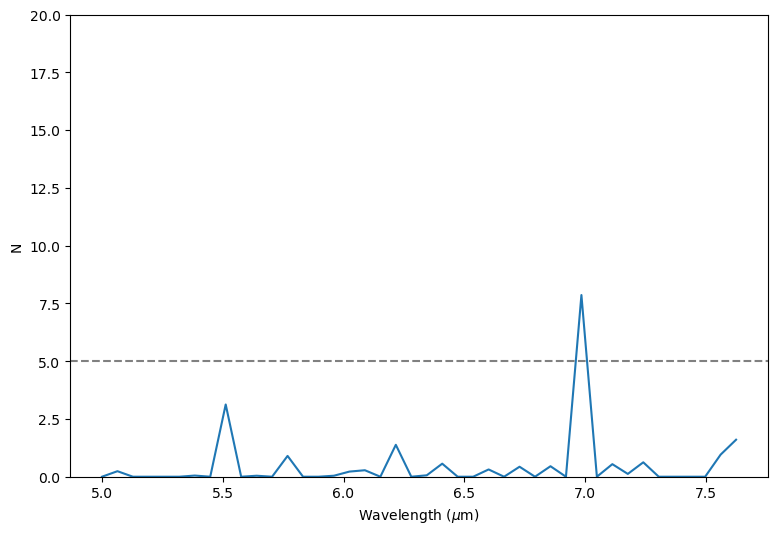

Significant detections:
N = 7.86 at (λ_0,i) = ('6.98', 31)
Strongest detection:
N = 7.86 at (λ_0,i) = ('6.98', 31)


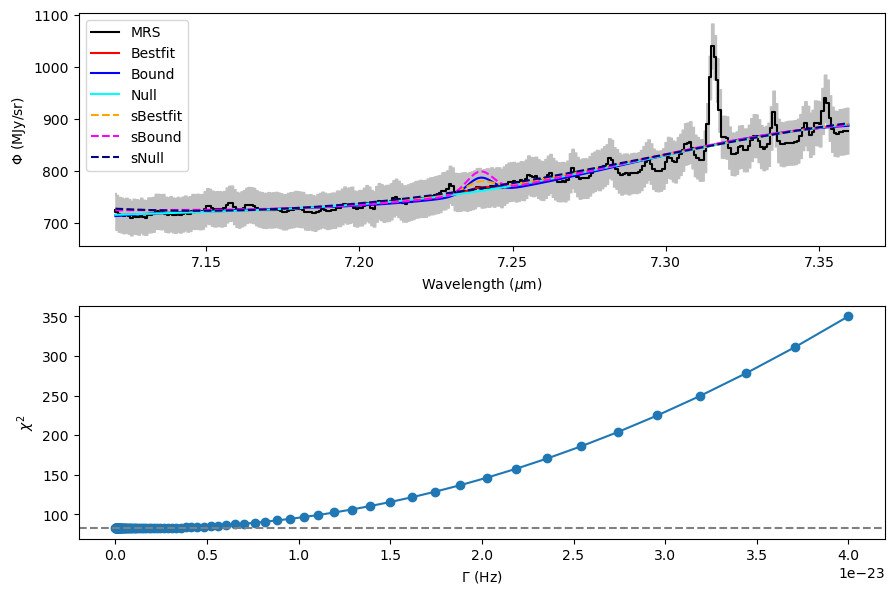

chi2 = 82.45462708982373 N = 0.6237898792457952


In [104]:
fitting_result(wvl_ch1, flux_ch1, err_ch1, wvl_bd_ch1, gammaTest1_cont, contChi2_ch1, N1, 
               plot_i=35, sim_i=2,
               modelFit=modelFit_ch1,
               simFit=simFit_ch1, 
               #simData=simData_ch1,
               N_lim = (0,20),
               flux_lim = (),
               # chi2_lim = (0,1000),
               # gamma_lim = (0,5e-23)
              )

#### - Remark: except for i=31 (non-DM line) the other detections are likely statistical

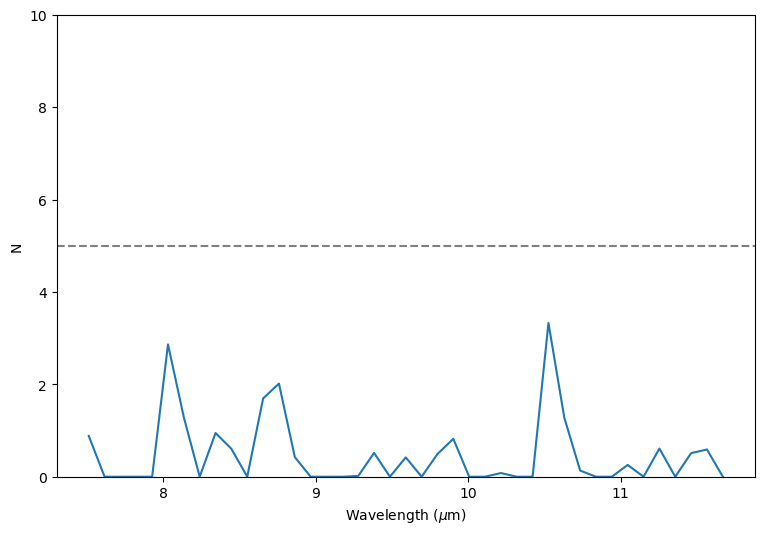

Significant detections:
Strongest detection:
N = 3.33 at (λ_0,i) = ('10.53', 29)


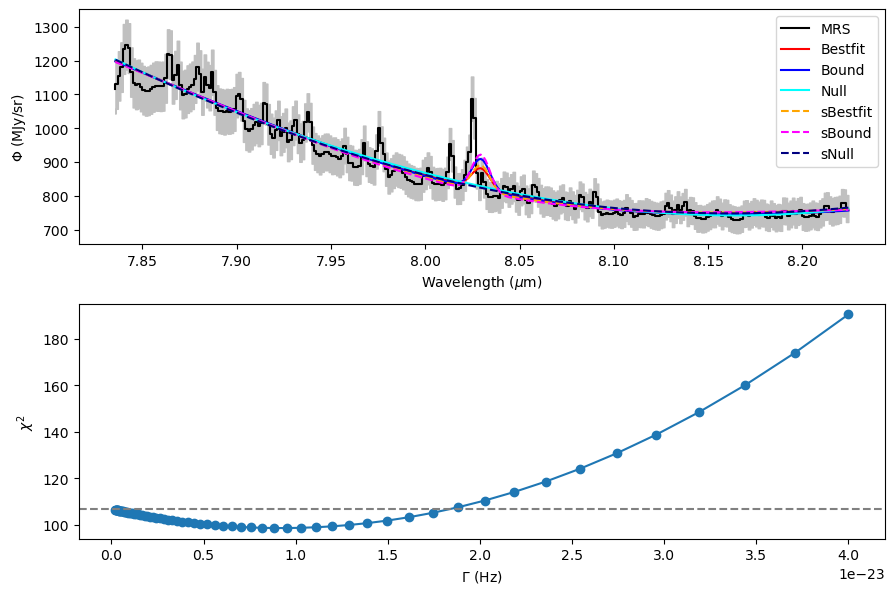

chi2 = 98.69025941889096 N = 2.863768180256578


In [105]:
fitting_result(wvl_ch2, flux_ch2, err_ch2, wvl_bd_ch2, gammaTest2_cont, contChi2_ch2, N2, 
               plot_i=5, sim_i=1,
               modelFit=modelFit_ch2,
               simFit=simFit_ch2, 
               #simData=simData_ch2,
               N_lim = (0,10),
               plotRange=50
               # chi2_lim = (0,2500),
               # gamma_lim = (0,5e-23)
              )

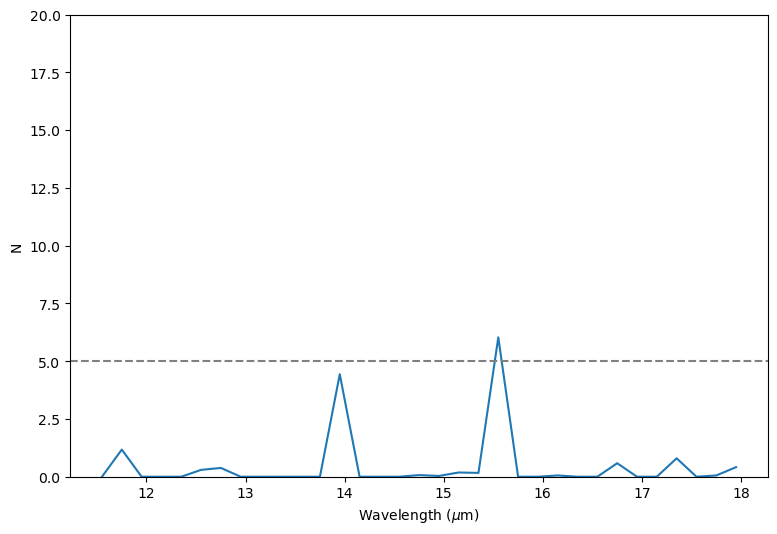

Significant detections:
N = 6.03 at (λ_0,i) = ('15.55', 20)
Strongest detection:
N = 6.03 at (λ_0,i) = ('15.55', 20)


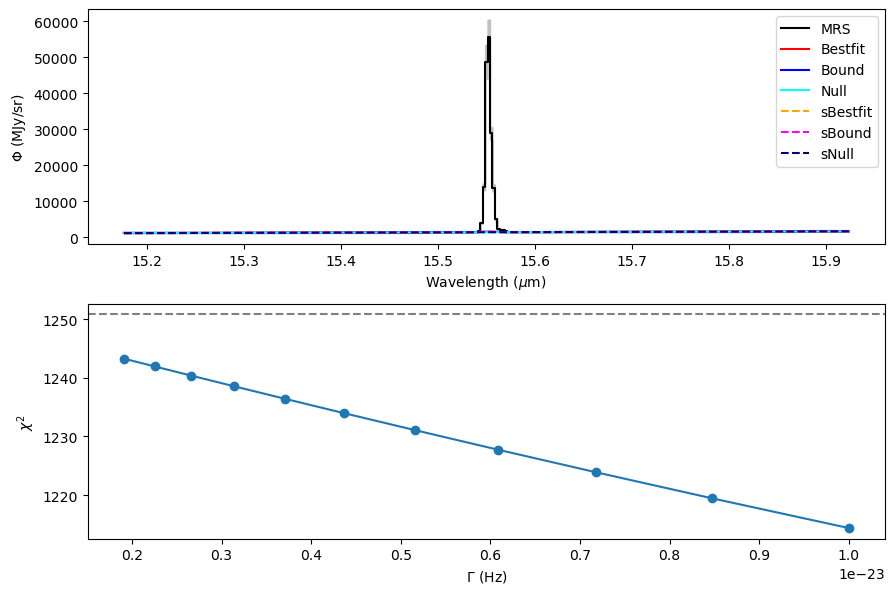

chi2 = 1214.3896085274216 N = 6.033837544278097


In [112]:
fitting_result(wvl_ch3, flux_ch3, err_ch3, wvl_bd_ch3, gammaTest3_cont, contChi2_ch3, N3, 
               plot_i=20, sim_i=0,
               modelFit=modelFit_ch3,
               simFit=simFit_ch3, 
               #simData=simData_ch3,
               N_lim = (0,20),
               plotRange=10
               # chi2_lim = (0,1550),
               # gamma_lim = (0,1e-22)
              )

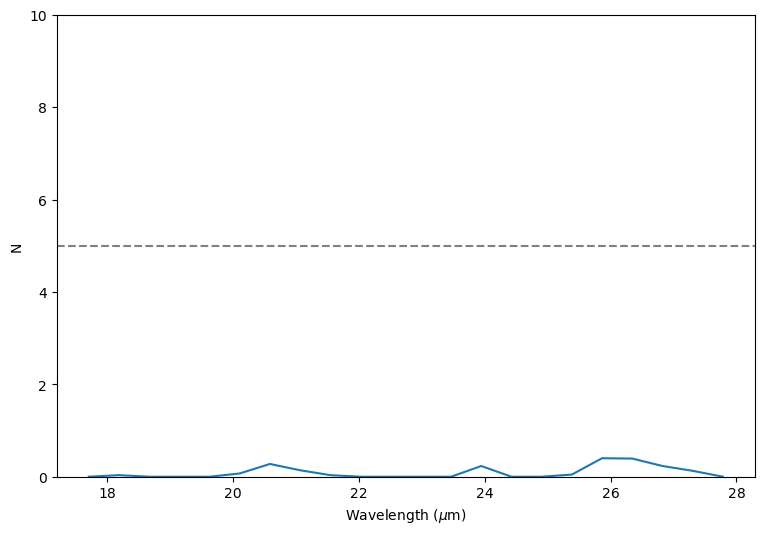

Significant detections:
Strongest detection:
N = 0.40 at (λ_0,i) = ('25.86', 17)


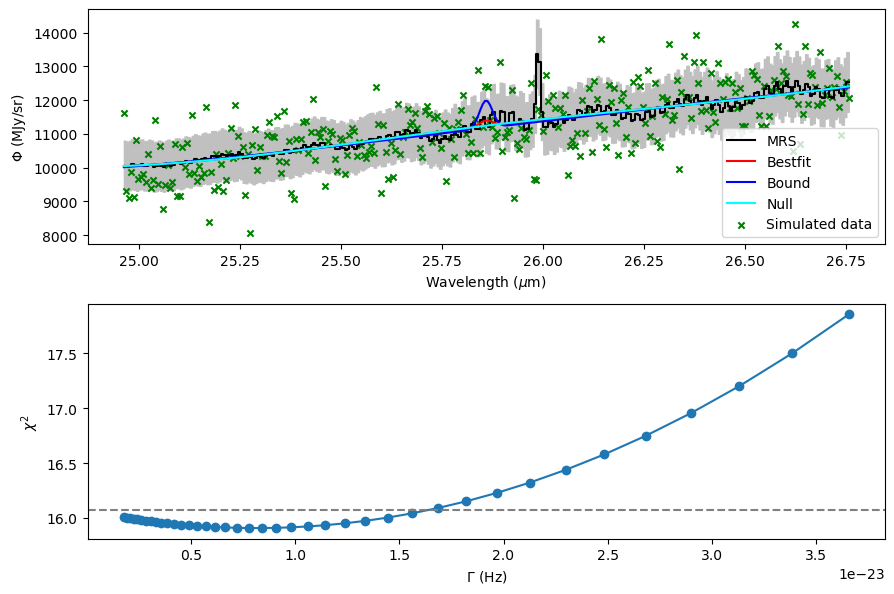

chi2 = 15.90806388282262 N = 0.40016911163505076


In [111]:
fitting_result(wvl_ch4, flux_ch4, err_ch4, wvl_bd_ch4, gammaTest4_cont, contChi2_ch4, N4, 
               plot_i=17, sim_i=0,
               modelFit=modelFit_ch4,
               #simFit=simFit_ch4, 
               simData=simData_ch4,
               N_lim = (0,10),
               plotRange=20
               # chi2_lim = (0,100),
               # gamma_lim = (0,1e-22)
              )

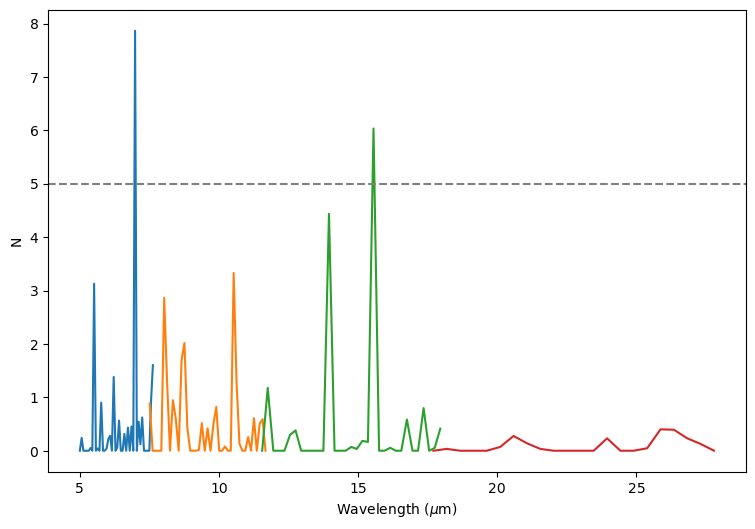

In [27]:
#Detection significance:
plt.figure(figsize=(9,6))
plt.plot(wvl_bd_ch1,N1)
plt.plot(wvl_bd_ch2,N2)
plt.plot(wvl_bd_ch3,N3)
plt.plot(wvl_bd_ch4,N4)
plt.axhline(y = 5, color = 'grey', linestyle = '--') 
plt.xlabel('Wavelength ($\\mu$m)')
plt.ylabel('N')
plt.show()

# Testing

(array([ 4., 12., 18., 18., 15., 20.,  8., 21.,  9., 17., 11.,  6.,  7.,
        11.,  8.,  4.,  1.,  5.,  3.,  2.]),
 array([5.68808912e-26, 8.05317765e-26, 1.04182662e-25, 1.27833547e-25,
        1.51484433e-25, 1.75135318e-25, 1.98786203e-25, 2.22437088e-25,
        2.46087974e-25, 2.69738859e-25, 2.93389744e-25, 3.17040630e-25,
        3.40691515e-25, 3.64342400e-25, 3.87993286e-25, 4.11644171e-25,
        4.35295056e-25, 4.58945942e-25, 4.82596827e-25, 5.06247712e-25,
        5.29898598e-25]),
 <BarContainer object of 20 artists>)

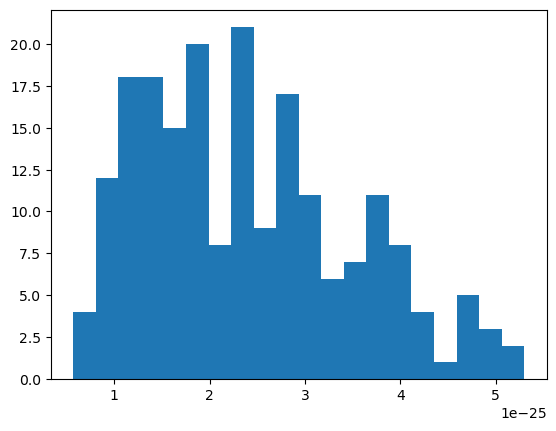

In [24]:
plt.hist(simGammaBd_ch1[12,:],bins=20)

(array([ 1.,  5.,  3., 10., 12., 22., 22., 23., 19., 18., 16., 18., 15.,
         5.,  3.,  2.,  1.,  3.,  0.,  2.]),
 array([1.00199223e-25, 1.53317023e-25, 2.06434822e-25, 2.59552621e-25,
        3.12670420e-25, 3.65788220e-25, 4.18906019e-25, 4.72023818e-25,
        5.25141618e-25, 5.78259417e-25, 6.31377216e-25, 6.84495015e-25,
        7.37612815e-25, 7.90730614e-25, 8.43848413e-25, 8.96966213e-25,
        9.50084012e-25, 1.00320181e-24, 1.05631961e-24, 1.10943741e-24,
        1.16255521e-24]),
 <BarContainer object of 20 artists>)

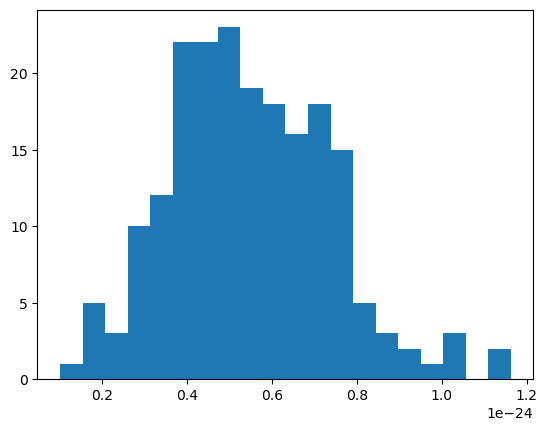

In [25]:
plt.hist(simGammaBd_ch2[14,:],bins=20)

(array([10., 18., 20., 23., 18., 20.,  7., 13., 12., 12.,  9.,  3.,  6.,
         4., 11.,  7.,  4.,  2.,  0.,  1.]),
 array([1.04291282e-25, 1.46277910e-25, 1.88264537e-25, 2.30251164e-25,
        2.72237792e-25, 3.14224419e-25, 3.56211046e-25, 3.98197673e-25,
        4.40184301e-25, 4.82170928e-25, 5.24157555e-25, 5.66144183e-25,
        6.08130810e-25, 6.50117437e-25, 6.92104065e-25, 7.34090692e-25,
        7.76077319e-25, 8.18063947e-25, 8.60050574e-25, 9.02037201e-25,
        9.44023829e-25]),
 <BarContainer object of 20 artists>)

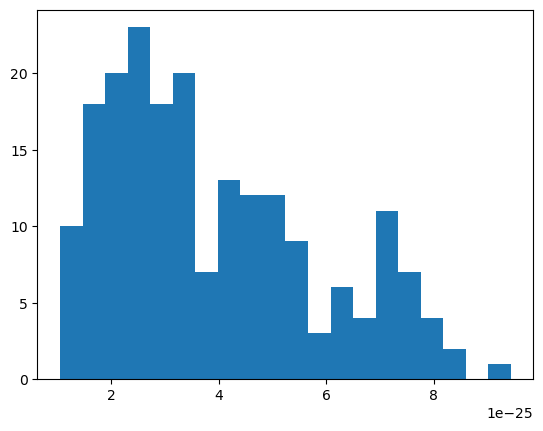

In [26]:
plt.hist(simGammaBd_ch3[6,:],bins=20)

(array([ 5., 15., 21., 16., 18., 14., 16., 18.,  9., 15.,  6., 13., 12.,
         8.,  7.,  3.,  1.,  0.,  1.,  2.]),
 array([3.17244768e-25, 4.41753230e-25, 5.66261692e-25, 6.90770154e-25,
        8.15278616e-25, 9.39787078e-25, 1.06429554e-24, 1.18880400e-24,
        1.31331246e-24, 1.43782092e-24, 1.56232939e-24, 1.68683785e-24,
        1.81134631e-24, 1.93585477e-24, 2.06036323e-24, 2.18487170e-24,
        2.30938016e-24, 2.43388862e-24, 2.55839708e-24, 2.68290554e-24,
        2.80741400e-24]),
 <BarContainer object of 20 artists>)

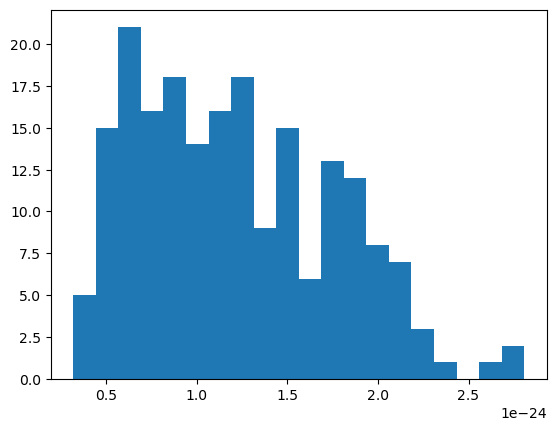

In [27]:
plt.hist(simGammaBd_ch4[5,:],bins=20)

In [28]:
a=[(np.zeros(2),2),(np.zeros(2),3),2]
print(a[0][0])

[0. 0.]


In [29]:
print(len(a))

3
